<a href="https://colab.research.google.com/github/MichaelTj02/FinalProject_Group1/blob/main/CombinedModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Functions and imports to run

In [30]:
from ultralytics import YOLO
import cv2
from matplotlib import pyplot as plt

In [31]:
# Function to capture license plate within the rider bounding box (for cases where there are multiple riders)
def is_within_bbox(inner_bbox, outer_bbox):
    x1, y1, x2, y2 = inner_bbox
    X1, Y1, X2, Y2 = outer_bbox
    return X1 <= x1 <= X2 and X1 <= x2 <= X2 and Y1 <= y1 <= Y2 and Y1 <= y2 <= Y2

In [32]:
# Process image
def process_image(image_path):
    # Load the image
    image = cv2.imread(image_path)

    # Run the first YOLO model
    results = helmet_model(image)

    # Iterate through detections
    for result in results[0].boxes.data.tolist():  # Extract detected bounding boxes
        x1, y1, x2, y2, confidence, class_id = result[:6]
        class_name = helmet_model.names[int(class_id)]  # Map class ID to label

        if class_name == "rider":
            rider_bbox = [x1, y1, x2, y2]

            # Check for a helmet in the rider's bounding box
            helmet_present = any(
                box for box in results[0].boxes.data.tolist()
                if helmet_model.names[int(box[5])] == "helmet" and is_within_bbox(box[:4], rider_bbox)
            )
            if helmet_present:
                print("Rider is wearing a helmet.")
                continue  # Skip if the rider has a helmet

            # Crop and show the rider who is not wearing a helmet
            rider_x1, rider_y1, rider_x2, rider_y2 = map(int, rider_bbox)
            cropped_rider = image[rider_y1:rider_y2, rider_x1:rider_x2]
            plt.imshow(cv2.cvtColor(cropped_rider, cv2.COLOR_BGR2RGB))
            plt.title("Rider without Helmet")
            plt.axis("off")
            plt.show()

            # Check for a license plate in the rider's bounding box
            license_plate = next(
                (
                    box for box in results[0].boxes.data.tolist()
                    if helmet_model.names[int(box[5])] == "number plate" and is_within_bbox(box[:4], rider_bbox)
                ),
                None,
            )

            if license_plate:
                # Crop the license plate from the image
                plate_x1, plate_y1, plate_x2, plate_y2 = map(int, license_plate[:4])
                cropped_plate = image[plate_y1:plate_y2, plate_x1:plate_x2]

                # Show the cropped license plate image
                plt.imshow(cv2.cvtColor(cropped_plate, cv2.COLOR_BGR2RGB))
                plt.title("Cropped License Plate")
                plt.axis("off")
                plt.show()

                # Run the second YOLO model for character recognition
                plate_results = plate_model(cropped_plate)

                # Extract detected characters and their bounding boxes
                detected_chars = [
                    {
                        "char": plate_model.names[int(box[5])],  # Character label
                        "bbox": box[:4],  # Bounding box of the character
                    }
                    for box in plate_results[0].boxes.data.tolist()
                ]

                # Sort characters first by y-coordinate, then by x-coordinate for each row
                sorted_chars = sorted(
                    detected_chars,
                    key=lambda c: (c["bbox"][1], c["bbox"][0])  # Sort by top (y1), then left (x1)
                )

                # Concatenate characters to form the license plate text
                license_plate_text = "".join(char["char"] for char in sorted_chars)

                # Output the result
                print(f"Rider without helmet. License plate text: {license_plate_text}")
            else:
                print("Rider without helmet, but no license plate detected. License plate text: Null.")

# Combined model

In [33]:
# Load YOLOv8 models
helmet_model = YOLO(r"C:\Users\mtj02\Desktop\FinalProject_Group1\Best_MotorcycleModel\weights\best.pt")
plate_model = YOLO(r"C:\Users\mtj02\Desktop\FinalProject_Group1\Best_LicensePlateModel\weights\best.pt")

In [34]:
# First image prediction
image_path = r"C:\Users\mtj02\Desktop\FinalProject_Group1\Datasets\MotorcycleHelmetDataset\images\train\new106.jpg"


0: 640x640 1 without helmet, 1 rider, 1 number plate, 3.0ms
Speed: 2.1ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


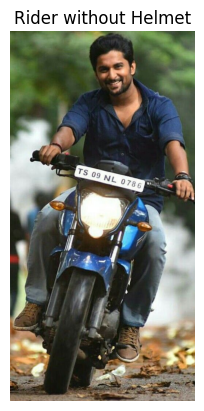

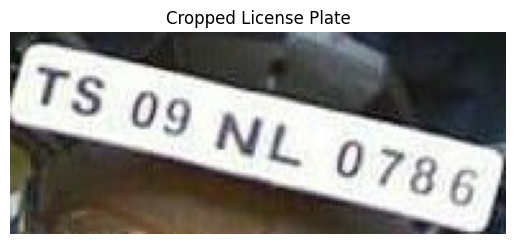


0: 288x640 1 L, 1 M, 1 T, 2 0s, 1 6, 1 7, 1 8, 1 9, 4.1ms
Speed: 0.0ms preprocess, 4.1ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)
Rider without helmet. License plate text: T09ML0786


In [35]:
process_image(image_path)

In [38]:
# Second image prediction
image_path = r"C:\Users\mtj02\Desktop\FinalProject_Group1\Datasets\MotorcycleHelmetDataset\images\val\new197.jpg"


0: 640x480 1 with helmet, 3 without helmets, 1 rider, 307.5ms
Speed: 3.6ms preprocess, 307.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


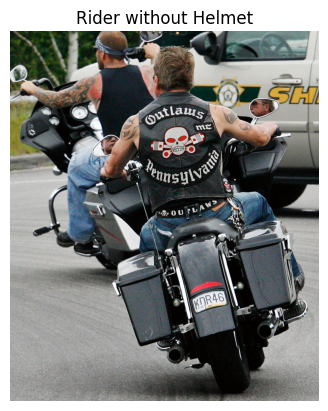

Rider without helmet, but no license plate detected. License plate text: Null.


In [39]:
process_image(image_path)

In [40]:
# Third image prediction
image_path = r"C:\Users\mtj02\Desktop\FinalProject_Group1\Datasets\MotorcycleHelmetDataset\images\val\new191.png"


0: 480x640 2 with helmets, 1 rider, 1 number plate, 42.4ms
Speed: 3.0ms preprocess, 42.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


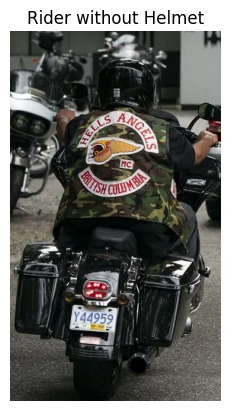

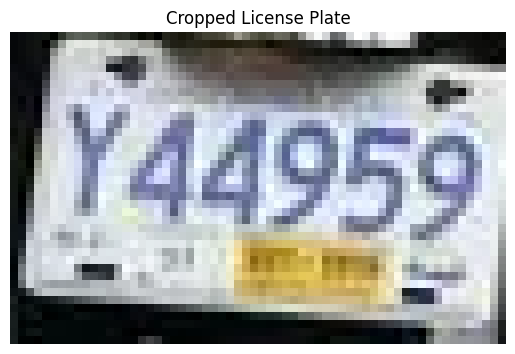


0: 416x640 1 M, 1 1, 1 4, 1 5, 2 9s, 36.0ms
Speed: 2.0ms preprocess, 36.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)
Rider without helmet. License plate text: 1M4959


In [41]:
process_image(image_path)

In [42]:
# Fourth image prediction
image_path = r"C:\Users\mtj02\Desktop\FinalProject_Group1\Datasets\MotorcycleHelmetDataset\images\train\new163.jpeg"


0: 448x640 4 with helmets, 5 riders, 4 number plates, 24.6ms
Speed: 3.0ms preprocess, 24.6ms inference, 6.1ms postprocess per image at shape (1, 3, 448, 640)


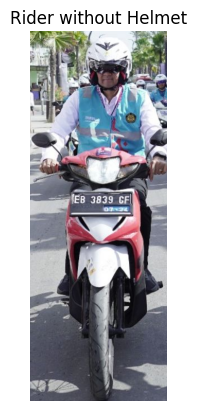

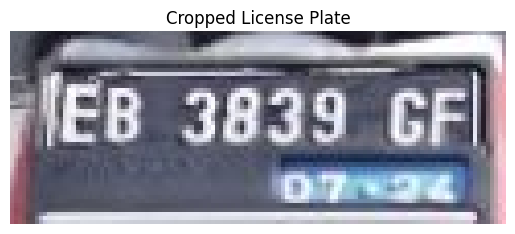


0: 256x640 1 F, 2 3s, 1 6, 1 8, 1 9, 87.5ms
Speed: 1.4ms preprocess, 87.5ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)
Rider without helmet. License plate text: F83639


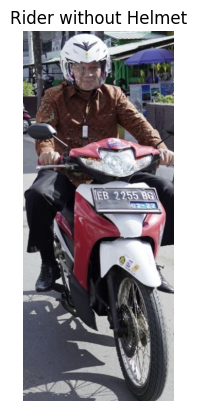

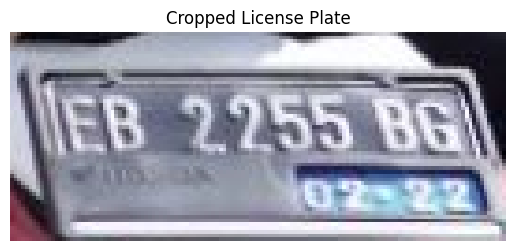


0: 288x640 2 5s, 5.1ms
Speed: 0.0ms preprocess, 5.1ms inference, 2.0ms postprocess per image at shape (1, 3, 288, 640)
Rider without helmet. License plate text: 55


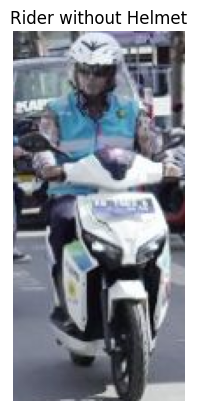

Rider without helmet, but no license plate detected. License plate text: Null.


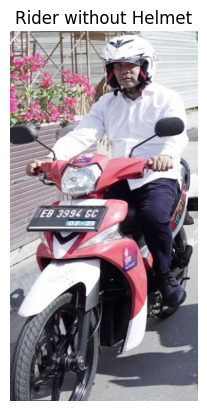

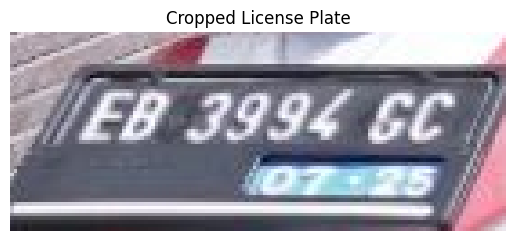


0: 288x640 1 6, 4.1ms
Speed: 1.0ms preprocess, 4.1ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)
Rider without helmet. License plate text: 6


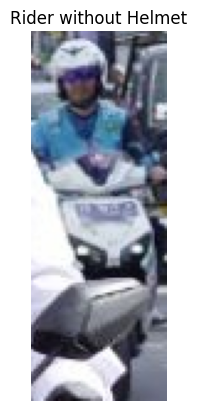

Rider without helmet, but no license plate detected. License plate text: Null.


In [43]:
process_image(image_path)

# API Testing